**Objetivo del Proyecto**

Construir un modelo de machine learning que prediga si un cliente de la empresa Interconnect cancelará su contrato.
Variable objetivo: EndDate.
- Si EndDate = "No" → el cliente no se ha ido
- Si EndDate ≠ "No" → el cliente se ha ido

# 📝 Etapa 1: Plan de trabajo

## 1️⃣ Análisis Exploratorio de Datos (EDA)
El análisis exploratorio nos ayudará a entender:
- Cuántos datos hay y cómo se relacionan entre sí (merge por customerID)
- Qué tipo de variables hay: categóricas, numéricas, fechas, etc.
- Si hay valores faltantes o columnas poco útiles
- Distribución de la variable objetivo

## 3️⃣ Plan de trabajo en pasos
**Plan de trabajo del proyecto:**
1. [ ] Realizar un análisis exploratorio de los archivos `contract.csv`, `personal.csv`, `internet.csv` y `phone.csv`, unificándolos por `customerID`.
2. [ ] Limpiar los datos: eliminar duplicados, manejar valores nulos y convertir las variables categóricas si es necesario.
3. [ ] Crear la variable objetivo como binaria: 0 = cliente activo (`EndDate == 'No'`), 1 = cliente que canceló.
4. [ ] Dividir el dataset en conjunto de entrenamiento y prueba, con estratificación por la variable objetivo.
5. [ ] Entrenar varios modelos de clasificación (Logistic Regression, Random Forest, Gradient Boosting, etc.) y evaluar con AUC-ROC.
6. [ ] Elegir el mejor modelo y optimizarlo con validación cruzada.
7. [ ] Redactar el informe final, documentando los pasos, problemas encontrados, decisiones tomadas y resultado final.


# Limpieza y preparación de datos

### 1. Importación de librerías

In [1]:
!brew install libomp 

/usr/bin/sh: 1: brew: not found


In [2]:
# Librerías para manipulación de datos
import pandas as pd
import re
from datetime import datetime, timedelta

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import resample

# Librerías para división y manejo de datos
from sklearn.model_selection import train_test_split
from collections import Counter

# Librerías para modelos predictivos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Librerías para validación cruzada y métricas
from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn.metrics import (make_scorer, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score)

# Otras librerías
import numpy as np
from sklearn.compose import ColumnTransformer

### 2. Carga y combinación de los datos

In [3]:
# Cargamos los archivos CSV que forman parte del dataset
platform_path = '/datasets/final_provider/'
contract = pd.read_csv(platform_path + 'contract.csv')
personal = pd.read_csv(platform_path + 'personal.csv')
internet = pd.read_csv(platform_path + 'internet.csv')
phone = pd.read_csv(platform_path + 'phone.csv')

# Confirmar la carga mostrando 5 filas de cada dataset
print("Contract Dataset:")
print(contract.head())

print("\nPersonal Dataset:")
print(personal.head())

print("\nInternet Dataset:")
print(internet.head())
 
print("\nPhone Dataset:")
print(phone.head())

Contract Dataset:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  

Personal Dataset:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes    

In [4]:
# Vamos a unir los datasets por la columna 'customerID' usando inner join para conservar solo clientes comunes a todos
merged_data = contract.merge(personal, on='customerID', how='inner') \
                      .merge(internet, on='customerID', how='inner') \
                      .merge(phone, on='customerID', how='inner')

# Confirmar la unión exitosa
print(f"Dimensiones del dataset combinado: {merged_data.shape}")
print()
print(merged_data.head())

Dimensiones del dataset combinado: (4835, 20)

   customerID   BeginDate              EndDate            Type  \
0  5575-GNVDE  2017-04-01                   No        One year   
1  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
2  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
3  9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
4  1452-KIOVK  2018-04-01                   No  Month-to-month   

  PaperlessBilling            PaymentMethod  MonthlyCharges TotalCharges  \
0               No             Mailed check           56.95       1889.5   
1              Yes             Mailed check           53.85       108.15   
2              Yes         Electronic check           70.70       151.65   
3              Yes         Electronic check           99.65        820.5   
4              Yes  Credit card (automatic)           89.10       1949.4   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0    Male            

### 3. Manejo de valores ausentes e inconsistencias 

In [5]:
# Renombramos las columnas con formato CamelCase
merged_data.rename(columns={'CustomerID': 'CustomerId', 'gender': 'Gender'}, inplace=True)

# Verificamos los nuevos nombres de las columnas
print("Nuevos nombres de las columnas:")
print(merged_data.columns)

Nuevos nombres de las columnas:
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')


In [6]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   Gender            4835 non-null   object 
 9   SeniorCitizen     4835 non-null   int64  
 10  Partner           4835 non-null   object 
 11  Dependents        4835 non-null   object 
 12  InternetService   4835 non-null   object 
 13  OnlineSecurity    4835 non-null   object 
 14  OnlineBackup      4835 non-null   object 
 15  DeviceProtection  4835 non-null   object 
 16  TechSupport       4835 non-null   object 


In [7]:
# Verificamos los tipos de datos en las columnas del dataset
print(merged_data.dtypes)

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
dtype: object


In [8]:
# Cambiar tipo de datos en columna 'BeginDate'(object) a datetime y con un formato que coincida con el dataset
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'], format='%Y-%m-%d', errors='coerce')
# Comprobamos
print(merged_data.dtypes)

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges                object
Gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object


In [9]:
# Tratamiento de valores ausentes
print("Valores ausentes en merged_data sin considerar 'No' en la columna 'EndDate'")
print(merged_data.isnull().sum())

Valores ausentes en merged_data sin considerar 'No' en la columna 'EndDate'
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


**Observación:** Si bien a primera vista merged_data no presenta valores faltantes, los registros con "No" en la columna EndDate no se identifican como ausentes (NaT) tras convertirla a tipo datetime, ya que Python los interpreta como cadenas. Por ello, es necesario reemplazar manualmente "No" por NaT antes de contabilizar los valores nulos.

In [10]:
# Reemplazamos los valores "No" en 'EndDate' por valores ausentes (NaT), para tratarlos como fechas faltantes
merged_data['EndDate'] = merged_data['EndDate'].replace('No', pd.NaT)
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

print(merged_data.head(3))

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  5575-GNVDE 2017-04-01        NaT        One year               No   
1  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
2  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges TotalCharges  Gender  SeniorCitizen  \
0      Mailed check           56.95       1889.5    Male              0   
1      Mailed check           53.85       108.15    Male              0   
2  Electronic check           70.70       151.65  Female              0   

  Partner Dependents InternetService OnlineSecurity OnlineBackup  \
0      No         No             DSL            Yes           No   
1      No         No             DSL            Yes          Yes   
2      No         No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  
0              Yes          No          No              No    

In [11]:
# La columna 'EndDate' es la única que tiene valores ausentes
print("Valores ausentes en merged_data después de cambiar 'No' por NaT en columna 'EndDate'")
print(merged_data.isnull().sum())

Valores ausentes en merged_data después de cambiar 'No' por NaT en columna 'EndDate'
customerID             0
BeginDate              0
EndDate             3249
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64


Los valores nulos en la columna EndDate indican que esa cantidad de clientes aún no finaliza el servicio y es probable que sean clientes activos.

In [12]:
"""# Creamos una nueva columna que indica si un cliente canceló (0 = sigue activo, 1 = canceló)
merged_data['OriginalChurn'] = merged_data['EndDate'].isna().astype(int)

print(merged_data['OriginalChurn'])

# Paso 1: Vamos a llenar los valores ausentes con la fecha más reciente del datatset
# Obtener la fecha más reciente (excluyendo NaT)
fecha_mas_reciente = merged_data['EndDate'].dropna().max()
print("La fecha más reciente es:", fecha_mas_reciente)

# Paso 2: Rellenar los NaT con esa fecha
merged_data['EndDate'] = merged_data['EndDate'].fillna(fecha_mas_reciente)

# Paso 3: Verificación
print(merged_data['EndDate'].isna().sum())  # Debería devolver 0

# Calculamos la duración del contrato en días
merged_data['ContractDuration'] = (merged_data['EndDate'] - merged_data['BeginDate']).dt.days

# Calcular la mediana de duración del contrato
median_duration = merged_data['ContractDuration'].median()
print(f"Duración mediana: {median_duration} días")

"""

'# Creamos una nueva columna que indica si un cliente canceló (0 = sigue activo, 1 = canceló)\nmerged_data[\'OriginalChurn\'] = merged_data[\'EndDate\'].isna().astype(int)\n\nprint(merged_data[\'OriginalChurn\'])\n\n# Paso 1: Vamos a llenar los valores ausentes con la fecha más reciente del datatset\n# Obtener la fecha más reciente (excluyendo NaT)\nfecha_mas_reciente = merged_data[\'EndDate\'].dropna().max()\nprint("La fecha más reciente es:", fecha_mas_reciente)\n\n# Paso 2: Rellenar los NaT con esa fecha\nmerged_data[\'EndDate\'] = merged_data[\'EndDate\'].fillna(fecha_mas_reciente)\n\n# Paso 3: Verificación\nprint(merged_data[\'EndDate\'].isna().sum())  # Debería devolver 0\n\n# Calculamos la duración del contrato en días\nmerged_data[\'ContractDuration\'] = (merged_data[\'EndDate\'] - merged_data[\'BeginDate\']).dt.days\n\n# Calcular la mediana de duración del contrato\nmedian_duration = merged_data[\'ContractDuration\'].median()\nprint(f"Duración mediana: {median_duration} días")

La idea inicial era inputar los datos ausentes con la última fecha registrada, pero esto podía generar sesgo en los datos, así que mejor será inputada con la mediana de los datos.

**Solución para valores ausentes en EndDate:**
Los valores ausentes en EndDate en realidad significan que los clientes aún no han terminado el contrato y por ende son clientes activos. Para calcular la duración promedio de los contratos necesitamos establecer una fecha que sea representativa y remplace a los NaT. Debido a que los datos abarcan hasta el año 2021 y en realidad no sabemos si en 2025 siguen activos, tenemos que establecer un límite que nos ayude a acercarnos a la realidad. 

Como los datos llegan hasta 2021, podemos usar una fecha de corte como "2021-12-31", para que:
Sea coherente con el rango temporal del dataset.
No sobreestimemos la duración de contratos actuales.
Aún refleje una duración mayor que la de clientes cancelados en años anteriores.


In [13]:
# Crear una columna que almacene el estado original antes de la imputación, 1 si cancelo, 0 si está activo
merged_data['OriginalChurn'] = merged_data['EndDate'].notna().astype(int)

# Aseguramos que las columnas sean tipo datetime
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'])
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'], errors='coerce')  # Los 'No' se vuelven NaT

# Definimos una fecha límite para clientes activos (por ejemplo, 31 de diciembre de 2021)
court_date = pd.to_datetime("2021-12-31")

# Sustituimos valores ausentes (NaT) en EndDate por esta fecha
merged_data['EndDate'] = merged_data['EndDate'].fillna(court_date)

# Calculamos duración del contrato en días 
merged_data['DaysContractDuration'] = ((merged_data['EndDate'] - merged_data['BeginDate']).dt.days)

# Verificamos la nueva columna
print(merged_data[['BeginDate', 'EndDate', 'DaysContractDuration']].head())

median_duration = merged_data['DaysContractDuration'].dropna().median()
print(f"Duración mediana: {median_duration} días")

   BeginDate    EndDate  DaysContractDuration
0 2017-04-01 2021-12-31                  1735
1 2019-10-01 2019-12-01                    61
2 2019-09-01 2019-11-01                    61
3 2019-03-01 2019-11-01                   245
4 2018-04-01 2021-12-31                  1370
Duración mediana: 1429.0 días


**¿Qué logramos?**

Clientes que no han cancelado ahora tienen una fecha final realista, sin suponer que siguen activos hasta 2025.
Esto permite calcular métricas como duración promedio, distribución de duración o análisis comparativos (clientes cancelados vs activos).

In [14]:
"""# Agregar columna 'ContracDuration' que calcula la duración del contrato en días restando la diferencia entre las columnas 'BeginDate' y 'EndDate'
merged_data['ContractDuration'] = (merged_data['EndDate'] - merged_data['BeginDate']).dt.days

# Calcular la mediana de duración del contrato sin contar los valores ausentes (NaT)
median_duration = merged_data['ContractDuration'].dropna().median()
print(f"Duración mediana: {median_duration} días")

# Imputar valores ausentes en columna 'EndDate' sumando los valores datatime de 'BeginDate' + la mediana de la duración de días del contrato
merged_data['EndDate'] = merged_data['EndDate'].fillna(merged_data['BeginDate'] + timedelta(days=median_duration))

# Imputar valores ausentes en 'ContractDuration' con la mediana
merged_data['ContractDuration'] = merged_data['ContractDuration'].fillna(median_duration)"""

'# Agregar columna \'ContracDuration\' que calcula la duración del contrato en días restando la diferencia entre las columnas \'BeginDate\' y \'EndDate\'\nmerged_data[\'ContractDuration\'] = (merged_data[\'EndDate\'] - merged_data[\'BeginDate\']).dt.days\n\n# Calcular la mediana de duración del contrato sin contar los valores ausentes (NaT)\nmedian_duration = merged_data[\'ContractDuration\'].dropna().median()\nprint(f"Duración mediana: {median_duration} días")\n\n# Imputar valores ausentes en columna \'EndDate\' sumando los valores datatime de \'BeginDate\' + la mediana de la duración de días del contrato\nmerged_data[\'EndDate\'] = merged_data[\'EndDate\'].fillna(merged_data[\'BeginDate\'] + timedelta(days=median_duration))\n\n# Imputar valores ausentes en \'ContractDuration\' con la mediana\nmerged_data[\'ContractDuration\'] = merged_data[\'ContractDuration\'].fillna(median_duration)'

In [15]:
# Verificamos que no hay valores ausentes dataset merged_data
print(merged_data.isna().sum())

customerID              0
BeginDate               0
EndDate                 0
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
Gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService         0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
MultipleLines           0
OriginalChurn           0
DaysContractDuration    0
dtype: int64


In [16]:
# Verificamos los cambios
merged_data.sample(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,OriginalChurn,DaysContractDuration
4770,2451-YMUXS,2014-07-01,2021-12-31,Two year,Yes,Bank transfer (automatic),64.55,4250.1,Male,1,...,DSL,Yes,Yes,No,Yes,No,No,Yes,0,2740
4743,1304-SEGFY,2014-02-01,2021-12-31,Two year,Yes,Electronic check,97.85,6841.3,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,2890
1111,9391-EOYLI,2019-01-01,2020-01-01,Month-to-month,Yes,Electronic check,80.45,950.2,Male,1,...,Fiber optic,No,No,No,No,No,Yes,No,1,365
2048,5131-PONJI,2016-01-01,2021-12-31,Month-to-month,Yes,Credit card (automatic),90.40,4494.65,Male,0,...,Fiber optic,No,Yes,Yes,No,Yes,No,No,0,2191
4256,2856-NNASM,2016-04-01,2019-11-01,Month-to-month,Yes,Mailed check,89.55,3856.75,Male,1,...,Fiber optic,No,No,No,No,Yes,Yes,No,1,1309
2570,5288-AHOUP,2019-03-01,2021-12-31,Month-to-month,Yes,Electronic check,78.50,874.2,Male,1,...,Fiber optic,No,No,No,No,No,Yes,No,0,1036
4224,0118-JPNOY,2017-12-01,2021-12-31,Month-to-month,Yes,Credit card (automatic),85.80,2193.65,Female,1,...,Fiber optic,Yes,No,No,No,Yes,No,No,0,1491
4718,8065-QBYTO,2014-03-01,2021-12-31,One year,Yes,Credit card (automatic),99.65,7181.25,Female,1,...,Fiber optic,Yes,Yes,No,Yes,Yes,No,Yes,0,2862
386,1342-JPNKI,2019-01-01,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),86.05,834.1,Male,0,...,Fiber optic,No,No,No,No,Yes,No,Yes,1,304
1242,3055-VTCGS,2014-11-01,2021-12-31,One year,No,Credit card (automatic),58.55,3503.5,Female,0,...,DSL,No,No,Yes,No,No,Yes,No,0,2617


In [17]:
# Cambiamos los datos en la columna TotalCharges(object) a tipo float
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')

In [18]:
# Verificar cuántos valores ausentes hay en la columna TotalCharges
print("Valores ausentes en columna TotalCharges:")
print(merged_data['TotalCharges'].isna().sum())

Valores ausentes en columna TotalCharges:
3


In [19]:
# Como no es una proporción significativa de los datos, los eliminamos
merged_data = merged_data.dropna(subset=['TotalCharges'])

# Verificamos si quedan valores ausentes en TotalCharges
print("Valores ausentes en TotalCharges después de eliminar:")
print(merged_data['TotalCharges'].isna().sum())

# Revisamos el nuevo tamaño del DataFrame
print("Número de filas después de eliminar valores ausentes:")
print(merged_data.shape[0])

# Restablecemos el índice para que sea consecutivo
merged_data = merged_data.reset_index(drop=True)

Valores ausentes en TotalCharges después de eliminar:
0
Número de filas después de eliminar valores ausentes:
4832


In [20]:
# Vamos a establecer las columnas categóricas y cambiar su tipo: Type, Gender, PaperlessBilling, PaymentMethod, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies y MultipleLines a tipo categórico
categorical_cols = ['Type', 'Gender', 'PaperlessBilling', 'PaymentMethod', 'Partner', 
                    'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'SeniorCitizen','StreamingTV', 'StreamingMovies', 
                    'MultipleLines']
merged_data[categorical_cols] = merged_data[categorical_cols].astype('category')

# Verificamos los cambios
print(merged_data.dtypes)


customerID                      object
BeginDate               datetime64[ns]
EndDate                 datetime64[ns]
Type                          category
PaperlessBilling              category
PaymentMethod                 category
MonthlyCharges                 float64
TotalCharges                   float64
Gender                        category
SeniorCitizen                 category
Partner                       category
Dependents                    category
InternetService               category
OnlineSecurity                category
OnlineBackup                  category
DeviceProtection              category
TechSupport                   category
StreamingTV                   category
StreamingMovies               category
MultipleLines                 category
OriginalChurn                    int64
DaysContractDuration             int64
dtype: object


In [21]:
# Verificar información general del dataset merged_data y contar valores ausentes
merged_data.info()
print()
print("Valores ausentes en merged_data:")
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customerID            4832 non-null   object        
 1   BeginDate             4832 non-null   datetime64[ns]
 2   EndDate               4832 non-null   datetime64[ns]
 3   Type                  4832 non-null   category      
 4   PaperlessBilling      4832 non-null   category      
 5   PaymentMethod         4832 non-null   category      
 6   MonthlyCharges        4832 non-null   float64       
 7   TotalCharges          4832 non-null   float64       
 8   Gender                4832 non-null   category      
 9   SeniorCitizen         4832 non-null   category      
 10  Partner               4832 non-null   category      
 11  Dependents            4832 non-null   category      
 12  InternetService       4832 non-null   category      
 13  OnlineSecurity    

#### **Carga y Unión de Datos**  
Los datasets (`contract`, `personal`, `phone`, e `internet`) se cargaron localmente desde la ruta `/proyecto/datasets/final_provider/` para garantizar accesibilidad. Estos se combinaron en un único DataFrame (`merged_data`) mediante un **inner join**, utilizando `customerID` como clave primaria. Para mantener consistencia, los nombres de las columnas se estandarizaron con **CamelCase**.  

#### **Manejo de Fechas y Valores Nulos**  
- Las columnas `EndDate` y `BeginDate` se convirtieron al formato **datetime**.  
- Inicialmente, los valores nulos en `EndDate` se imputaron con la fecha más reciente, pero esta estrategia se descartó debido al alto porcentaje de datos ausentes, lo que podría introducir sesgos.  
- Para `EndDate`, los valores faltantes se rellenaron con la la fecha más reciente.  

#### **Feature Engineering y Limpieza**  
- Se creó la columna `OriginalChurn` a partir de `EndDate`, donde los valores nulos se mapearon como `True` (1) y los no nulos como `False` (0), convirtiéndolos luego a enteros (`astype(int)`).  
- La columna `TotalCharges` se transformó de **object** a **float**, y dado que solo contenía 3 valores ausentes (poco significativos), se eliminaron esas filas.  

#### **Optimización de Columnas Categóricas**  
Las variables categóricas (`Type`, `Gender`, `PaperlessBilling`, etc.) se convirtieron al tipo **category** y se agruparon en la variable `categorical_cols` para facilitar su manejo.  

#### **Validación Final**  
Se verificó la consistencia de los tipos de datos y la cantidad de valores nulos en todas las columnas, asegurando la calidad del dataset procesado.  


### 3. Análisis Estadístico

In [22]:
# Comenzamos mostrandos las métricas estadísticas
merged_data.describe()

,MonthlyCharges,TotalCharges,OriginalChurn,DaysContractDuration
count,4832.000000,4832.000000,4832.000000,4832.000000
mean,81.761207,2902.470788,0.328228,1476.382657
std,18.306134,2415.564128,0.469617,931.730954
min,42.900000,42.900000,0.000000,30.000000
25%,69.787500,659.600000,0.000000,752.500000
50%,82.500000,2350.625000,0.000000,1429.000000
75%,95.700000,4871.150000,1.000000,2344.000000
max,118.750000,8684.800000,1.000000,2890.000000


### **Análisis Estadístico Descriptivo**

#### **1. MonthlyCharges (Cargos Mensuales)**
- **Rango**: $42.90 (mínimo) a $118.75 (máximo).  
- **Media**: $81.76 ± $18.31 (desviación estándar).  
  - **Distribución**:  
    - **Mediana (50%) ≈ Media** ($82.50 vs. $81.76) → Distribución simétrica.  
    - **IQR (25%-75%)**: $69.79–$95.70 → 50% central de clientes paga entre estos valores.  
- **Interpretación**:  
  - La mayoría de clientes tiene cargos cercanos a la media, con pocos outliers extremos (rango estrecho entre percentiles).  

#### **2. TotalCharges (Cargos Totales Acumulados)**
- **Rango**: $42.90 (mínimo) a $8,684.80 (máximo).  
- **Media**: $2,902.47 ± $2,415.56 (alta dispersión).  
  - **Distribución**:  
    - **Mediana (50%) < Media** ($2,350.63 vs. $2,902.47) → **Sesgo positivo** (cola derecha).  
    - **IQR**: $659.60–$4,871.15 → Gran variabilidad en gastos acumulados.  
- **Interpretación**:  
  - 75% de clientes gasta ≤$4,871.15, pero algunos outliers elevan la media (ej.: clientes con contratos muy largos o planes premium).  

#### **3. DaysContractDuration (Duración de Contratos en Días)**
- **Rango**: 30 días (mínimo) a 2,890 días (~7.9 años).  
- **Media**: 1,476 días (~4 años) ± 932 días.  
  - **Distribución**:  
    - **Mediana (50%) ≈ Media** (1,429 vs. 1,476 días) → Distribución equilibrada.  
    - **IQR**: 753–2,344 días (~2–6.4 años) → Amplia diversidad en duraciones.  
- **Interpretación**:  
  - Aunque la mediana sugiere una duración típica de ~4 años, el IQR muestra que hay clientes con contratos mucho más cortos (25% con ≤753 días) o largos (25% con ≥2,344 días).  

---

### **Síntesis y Conclusiones**  
1. **Estabilidad en cargos mensuales**:  
   - Los clientes pagan tarifas mensuales consistentes (poca variabilidad relativa, sin sesgo pronunciado).  

2. **Alta heterogeneidad en cargos totales**:  
   - La gran desviación estándar y sesgo positivo en `TotalCharges` reflejan que:  
     - Algunos clientes generan ingresos significativamente mayores (posiblemente por antigüedad o planes costosos).  
     - **Oportunidad**: Investigar si los altos `TotalCharges` correlacionan con menor tasa de churn.  

3. **Duración de contratos polarizada**:  
   - El amplio IQR en `DaysContractDuration` sugiere dos perfiles:  
     - **Clientes a corto plazo** (25% con ≤2 años).  
     - **Clientes leales** (25% con ≥6.4 años).  
   - **Recomendación**: Segmentar estrategias de retención según antigüedad.  

4. **Relación entre variables**:  
   - Los clientes con mayor `TotalCharges` probablemente combinan:  
     - Alta `DaysContractDuration` (permanencia prolongada).  
     - `MonthlyCharges` en percentiles altos (planes premium).  


### 4. Visualización de datos


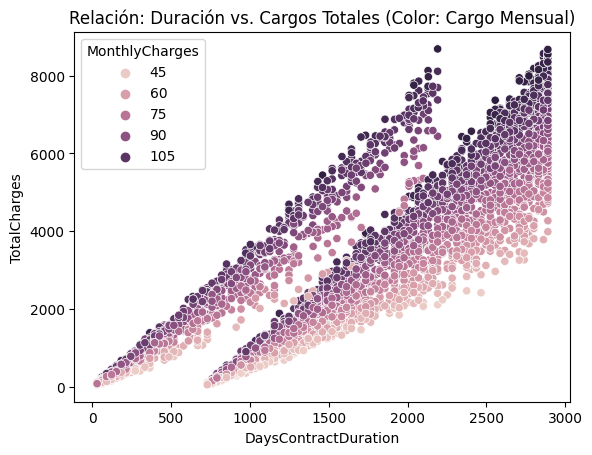

In [23]:
sns.scatterplot(data=merged_data, x='DaysContractDuration', y='TotalCharges', hue='MonthlyCharges')
plt.title('Relación: Duración vs. Cargos Totales (Color: Cargo Mensual)')
plt.show()

En la gráfica observamos que existe una relación positiva entre la duración del contrato y el total de los cargos. Asi mismo, las personas con cargos mensuales más altos, en su mayoría son aquellas con contratos más largos. Una buena suposición de esto sería que los clientes que confían más en la empresa son más propensos a tener gastos más altos.

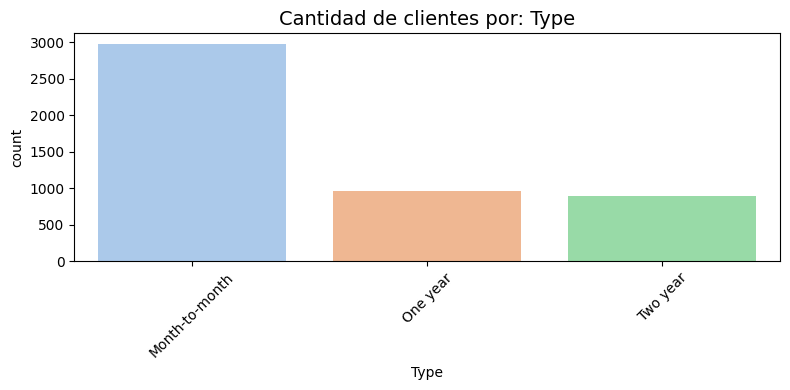

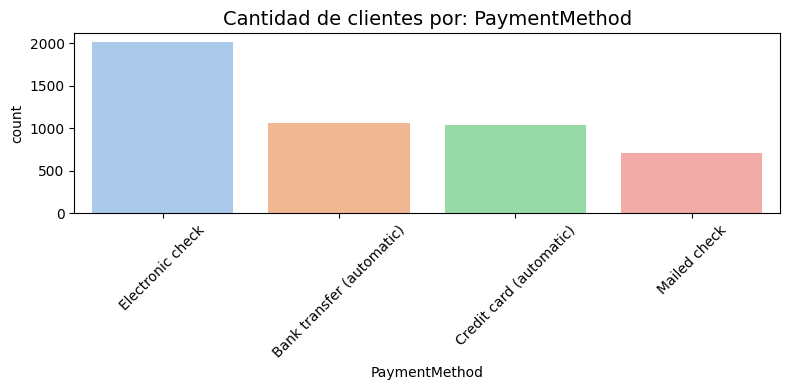

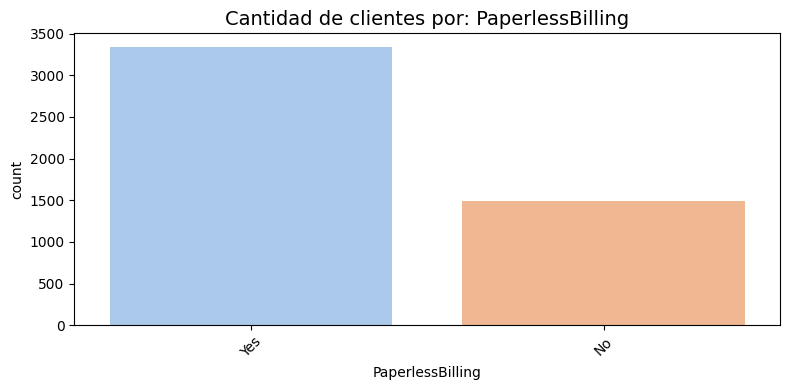

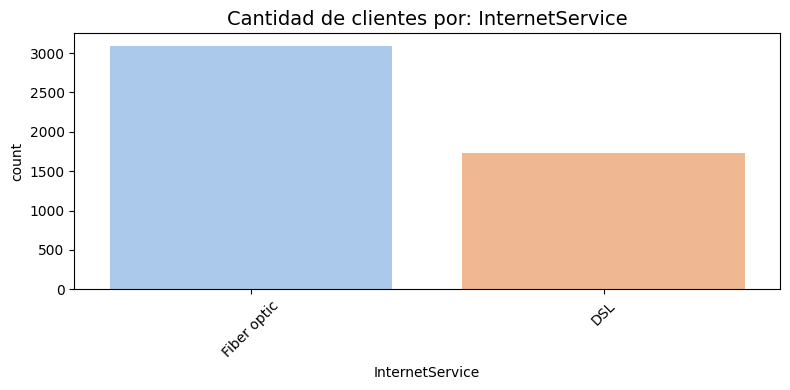

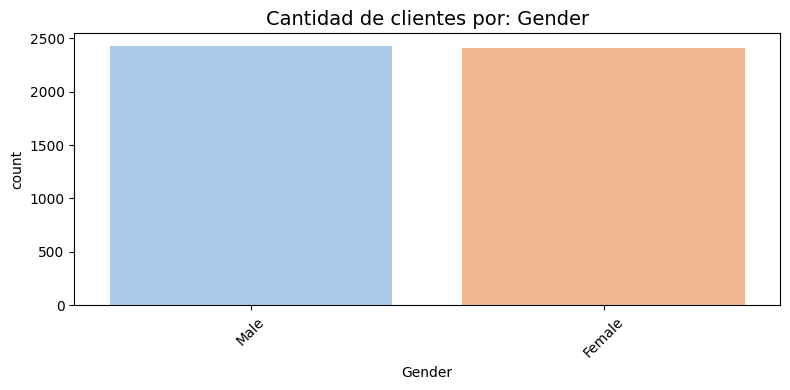

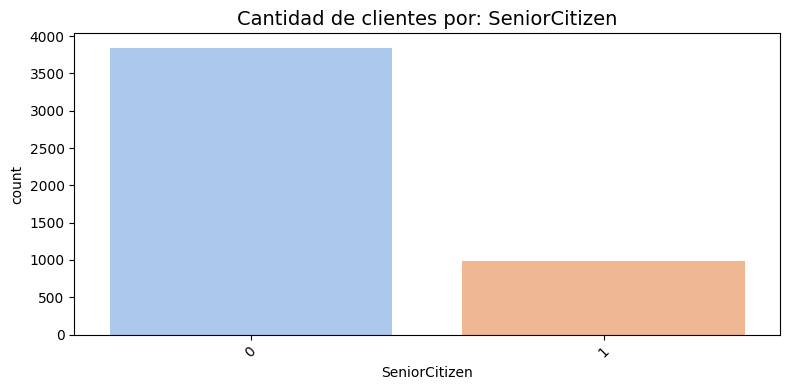

In [24]:
# Lista de variables categóricas a graficar
cat_vars = ['Type', 'PaymentMethod', 'PaperlessBilling', 'InternetService',
            'Gender', 'SeniorCitizen']

# Iteramos por cada variable para graficarla
for col in cat_vars:
    plt.figure(figsize=(8,4))  # Ajustamos el tamaño del gráfico
    sns.countplot(data=merged_data, x=col, order=merged_data[col].value_counts().index, palette="pastel")
    plt.title(f'Cantidad de clientes por: {col}', fontsize=14)
    plt.xticks(rotation=45)  # Rotamos etiquetas si es necesario
    plt.tight_layout()
    plt.show()


### 🔍 Análisis de distribución de variables categóricas

Al observar las gráficas de barras, se puede notar que **la mayoría de los clientes tienen contratos de tipo mensual**, mientras que los contratos a largo plazo (uno o dos años) son considerablemente menos comunes. Esto podría deberse a que los contratos mensuales ofrecen mayor flexibilidad, permitiendo a los usuarios cancelar sin compromisos largos, lo que también podría influir en la tasa de cancelación.

En cuanto a los **métodos de pago**, se observa que **la mayoría de los clientes usan pagos electrónicos mediante cheque (electronic check)**, seguidos de los pagos por correo (mailed check). Sin embargo, **muy pocas personas eligen el pago automático con tarjeta de crédito o transferencia bancaria**, lo cual podría estar relacionado con la desconfianza o falta de familiaridad con este tipo de automatización.

También es evidente que **una mayoría significativa de los usuarios utiliza el servicio de facturación electrónica (PaperlessBilling)**. Esto podría reflejar una preferencia por métodos más prácticos y modernos, además de estar en línea con prácticas sostenibles que reducen el uso de papel.

En relación con el tipo de servicio de internet, **la mayoría de los clientes cuenta con fibra óptica**, mientras que los que usan DSL son menos. Esta tendencia puede deberse a que la fibra óptica ofrece mayor velocidad y calidad de conexión, lo cual resulta más atractivo para los usuarios, aunque posiblemente también más costoso.

Por otro lado, **el género está casi equilibrado entre hombres y mujeres**, por lo que no parece haber una diferencia significativa en el servicio entre ambos grupos.

Finalmente, **hay una mayor proporción de personas no jubiladas en comparación con aquellas que sí lo están (SeniorCitizen)**, lo cual puede tener implicaciones importantes, ya que el estado laboral y la edad podrían influir en la duración del contrato, el tipo de servicios contratados o la propensión a cancelar.

---



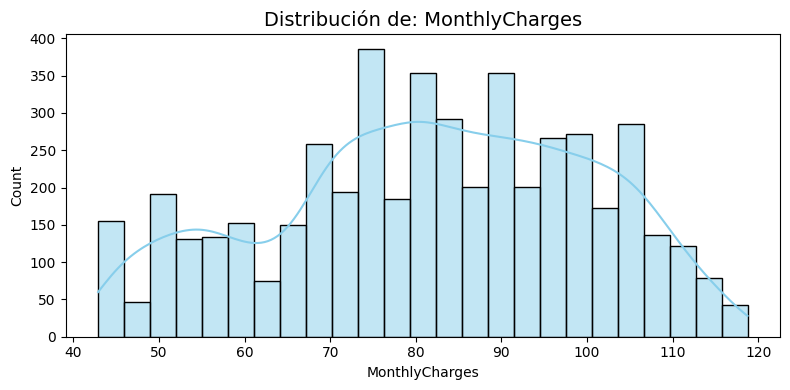

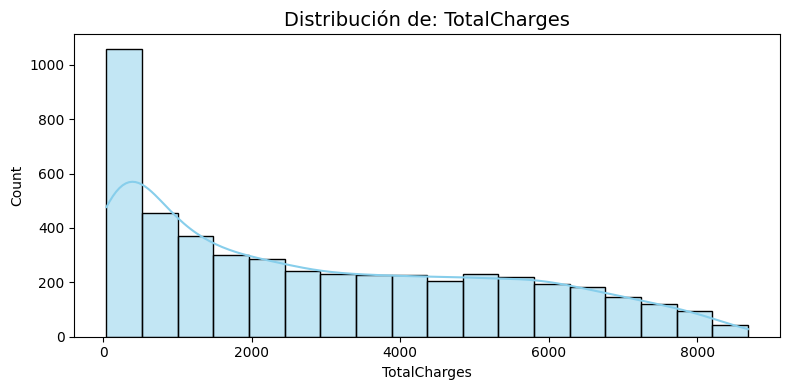

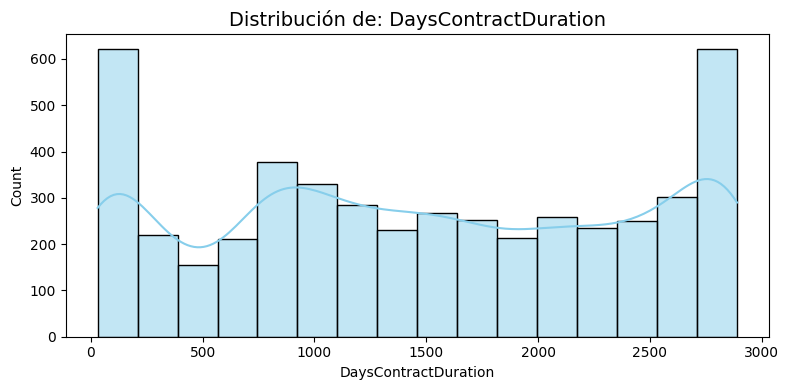

In [25]:
# Lista de variables numéricas
num_vars = ['MonthlyCharges', 'TotalCharges', 'DaysContractDuration']

# Convertimos TotalCharges a numérico si no lo has hecho
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')

# Graficamos distribuciones con histplot
for col in num_vars:
    plt.figure(figsize=(8,4))
    sns.histplot(data=merged_data, x=col, kde=True, color='skyblue')  # kde=True añade una curva suave
    plt.title(f'Distribución de: {col}', fontsize=14)
    plt.tight_layout()
    plt.show()


### 📊 Análisis de distribución de variables numéricas

La gráfica de distribución de los **MonthlyCharges (cargos mensuales)** tiene una forma muy peculiar, similar a un sombrero del Principito (o un elefante, como en el cuento 🐘🎩). Esto quiere decir que **los valores más comunes están concentrados en la parte media**, con una curva suave que cae a ambos lados. Específicamente, **la mayoría de los clientes paga entre 75 y 90 dólares al mes**, lo que probablemente representa los planes más populares o los servicios más contratados. Por otro lado, **muy pocas personas pagan menos de 70 o más de 105 dólares**, lo que sugiere que los planes muy baratos o muy costosos son poco frecuentes.

En cuanto a los **TotalCharges (cargos totales acumulados)**, la mayoría de los clientes acumula **menos de 2000 dólares**. Esto podría deberse a que muchos usuarios **tienen contratos relativamente cortos**, lo que limita el monto total que han pagado. Es decir, aunque sus cargos mensuales puedan ser altos, si llevan poco tiempo en la empresa, su acumulado aún no es tan elevado.

La distribución de la **ContractDuration en días** muestra una tendencia muy curiosa: **los valores tienden a concentrarse en los extremos**. Es decir, la mayoría de los clientes **o bien duran muy poco tiempo con la empresa (entre 0 y 300 días)**, o bien **permanecen por largos periodos (entre 2500 y 3000 días, aproximadamente 7 a 8 años)**. Esto podría indicar una especie de “efecto de filtro”: algunos usuarios prueban el servicio y lo cancelan rápidamente, mientras que otros se mantienen por muchos años, tal vez por satisfacción o porque tienen contratos más estables.

---


### Análisis de relación entre las cancelaciones y variables categóricas

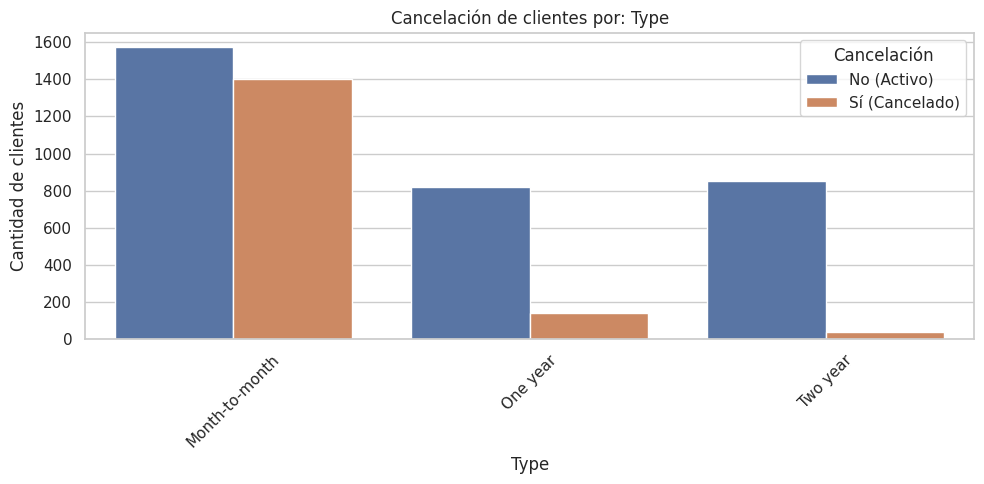

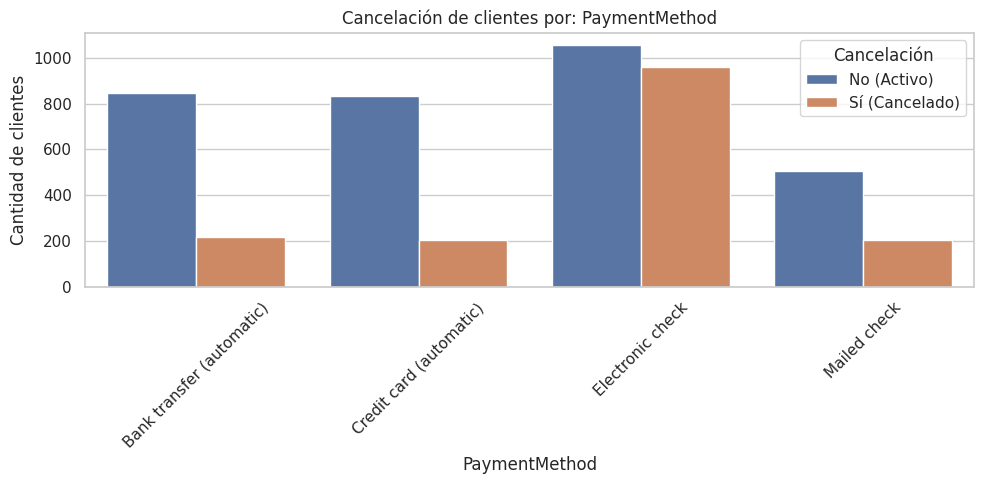

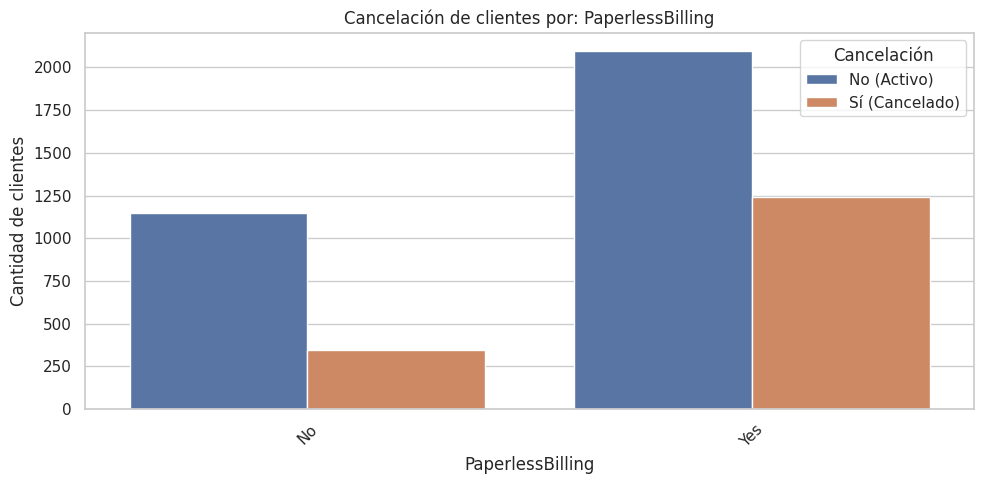

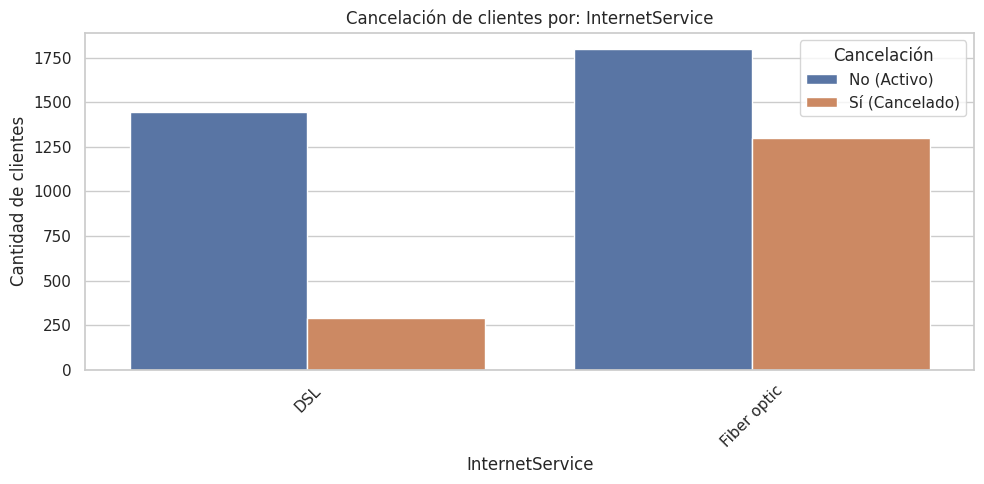

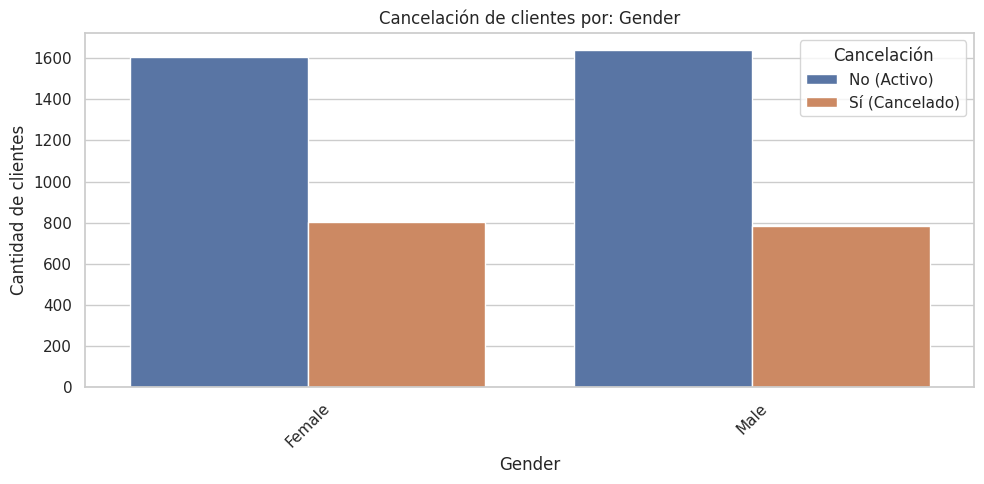

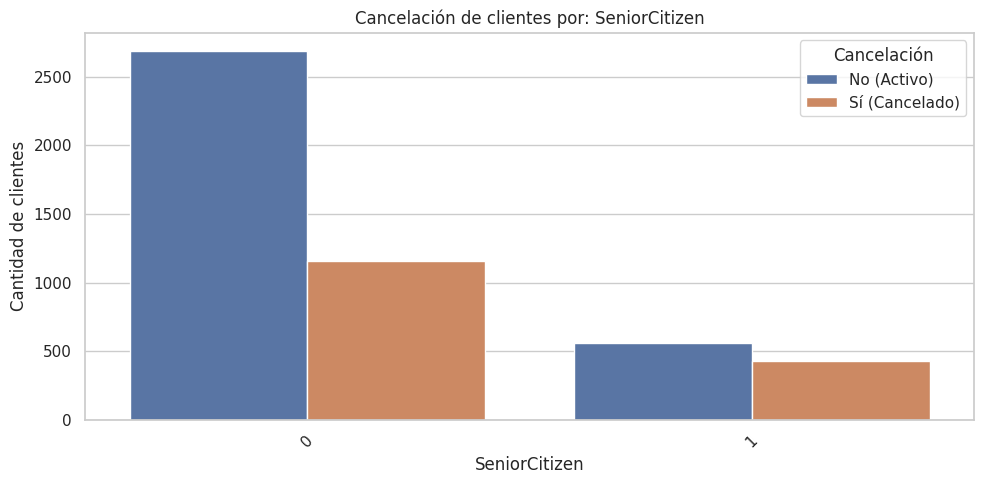

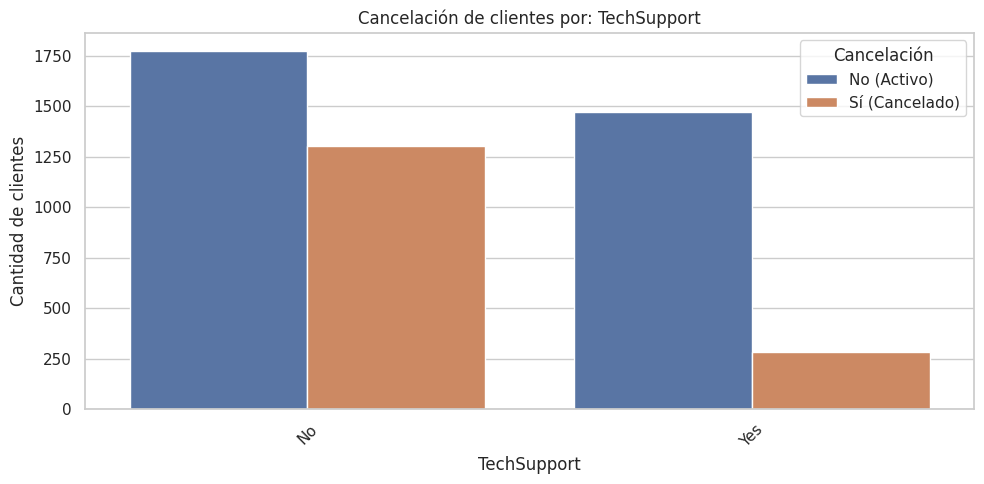

In [26]:
# Ajustamos estilo general de los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Lista de columnas categóricas a graficar
cat_cols = [
    'Type', 'PaymentMethod', 'PaperlessBilling', 'InternetService',
    'Gender', 'SeniorCitizen', 'TechSupport']

# Creamos una gráfica por cada variable categórica
for col in cat_cols:
    plt.figure()
    ax = sns.countplot(
        data=merged_data,
        x=col,
        hue='OriginalChurn',
        hue_order=[0, 1]  # Aseguramos el orden: 0 (No) primero, 1 (Sí) después
    )
    
    # Personalizamos la leyenda
    handles, _ = ax.get_legend_handles_labels()
    plt.legend(
        handles,
        ['No (Activo)', 'Sí (Cancelado)'],  # Etiquetas personalizadas
        title='Cancelación'
    )
    
    plt.title(f'Cancelación de clientes por: {col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Cantidad de clientes')
    plt.tight_layout()
    plt.show()

### 📊 Análisis gráfico de las características más relevantes en relación con la cancelación de clientes

Las gráficas comparativas nos permiten observar de forma visual la relación entre ciertas características del cliente y su tendencia a cancelar o permanecer activo en el servicio. A continuación, se describen los hallazgos más relevantes:

#### 🧾 Tipo de contrato

La mayor parte de los clientes activos tienen un contrato **mensual**, seguido por los de **un año** y **dos años**. También es importante notar que los contratos **por un día** son muy poco comunes, tanto en clientes activos como cancelados.

Entre los clientes que **cancelaron**, el tipo de contrato más común también es el mensual. Sin embargo, al comparar ambos grupos (activos y cancelados), se observa que:

* Hay **más personas activas** que canceladas con contrato mensual.
* En contratos de **un año**, la diferencia es aún mayor a favor de los clientes activos.
* En contratos de **dos años**, la diferencia es muy marcada: casi todos los clientes con este tipo de contrato **siguen activos**.

Esto sugiere que los contratos más largos están asociados con una menor tasa de cancelación, posiblemente porque representan un mayor compromiso o satisfacción con el servicio.

#### 💳 Método de pago

Al analizar los métodos de pago, encontramos que:

* **Transferencia bancaria automática** y **tarjeta de crédito automática** están asociados con **más clientes activos que cancelados**, lo que puede indicar comodidad o estabilidad financiera.
* En el caso de **cheque electrónico (Electronic check)**, la diferencia entre activos y cancelados es mucho menor. De hecho, es el **método con mayor número de cancelaciones**, lo cual podría relacionarse con una menor confianza en el servicio o usuarios menos satisfechos.
* Finalmente, en los **pagos por cheque tradicional (Mailed check)** también hay más clientes activos que cancelados, pero la proporción de cancelaciones es casi del **50%** respecto al total de usuarios con ese método.

#### 🧾 Facturación sin papel (Paperless Billing)

Los usuarios que tienen habilitada la **facturación sin papel** presentan un número mayor de clientes activos en comparación con los cancelados. Además, entre quienes **no usan** este servicio, la proporción de cancelaciones es aún menor, pero también hay **menos clientes en total**, lo que limita su impacto general.

#### 🌐 Tipo de servicio de internet

En cuanto al servicio de internet:

* Con **DSL**, hay una diferencia considerable a favor de los clientes activos.
* Con **fibra óptica**, aunque también hay más personas activas, la diferencia con respecto a los cancelados es **menor**.
  Esto podría indicar que los usuarios de fibra óptica cancelan con más frecuencia, tal vez por problemas técnicos o expectativas no cumplidas.

#### 👤 Género

La variable de género **no parece tener influencia significativa** en las cancelaciones. La proporción de hombres y mujeres cancelando o permaneciendo activos es muy similar.

#### 👵 ¿Está jubilado?

La **jubilación** muestra una ligera tendencia: los **no jubilados** son en su mayoría clientes activos. Entre los **jubilados**, los números están más equilibrados, aunque siguen siendo ligeramente más los que permanecen activos.

#### 👨‍💻 Soporte técnico (Tech support)

Por último, se observa una **clara tendencia** entre quienes **recibieron soporte técnico**: la mayoría **siguen activos**. Esto sugiere que brindar ayuda técnica puede mejorar la satisfacción y reducir la cancelación del servicio.

---


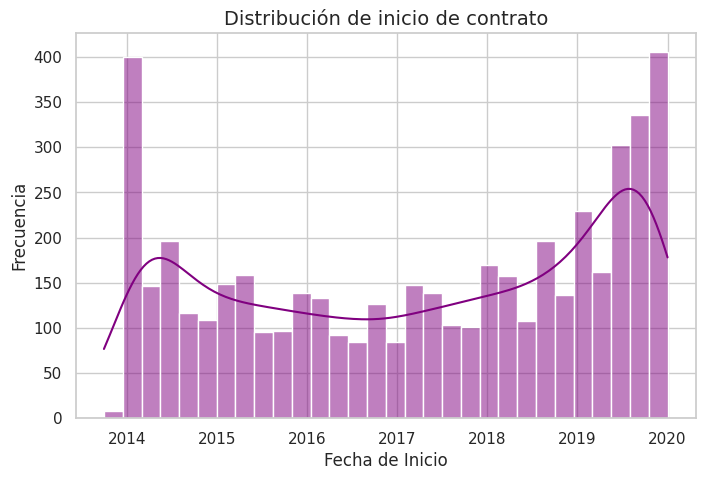

In [27]:
# Histograma de la fecha de inicio de los contratos
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['BeginDate'], kde=True, color='purple', bins=30)
plt.title('Distribución de inicio de contrato', fontsize=14)
plt.xlabel('Fecha de Inicio')
plt.ylabel('Frecuencia')
plt.show()

La gráfica revela un **patrón bimodal** en la adhesión de clientes, con picos significativos en **2014** y **2020**. Esto sugiere dos escenarios clave:  
1. **Origen de la compañía (2014)**: El alto volumen de contratos en este año podría indicar el lanzamiento inicial de la empresa o una campaña de captación masiva durante su primer año de operaciones.  
2. **Estrategia de crecimiento (2020)**: El segundo pico en 2020 podría asociarse a una **inversión agresiva en marketing**, la expansión a nuevos mercados o incluso factores externos (ej.: cambios regulatorios o demanda post-pandemia).  

Entre ambos períodos, se observa una **tendencia ascendente con fluctuaciones**, lo que refleja:  
- **Crecimiento orgánico**: Aumento progresivo en la base de clientes, con altibajos atribuibles a ciclos económicos, competencia o ajustes en estrategias comerciales.  
- **Estacionalidad**: Las variaciones podrían responder a promociones temporales o temporadas de alta demanda (ej.: fin de año).  
 
La distribución temporal de contratos evidencia dos picos destacados: uno en 2014 —posiblemente vinculado al año de fundación de la compañía— y otro en 2020, quizás impulsado por una reinversión en marketing o adaptaciones post-pandemia. Entre ambos, la tendencia creciente, aunque no lineal, refleja una expansión sostenida, interrumpida por fluctuaciones propias de ciclos comerciales o factores externos."


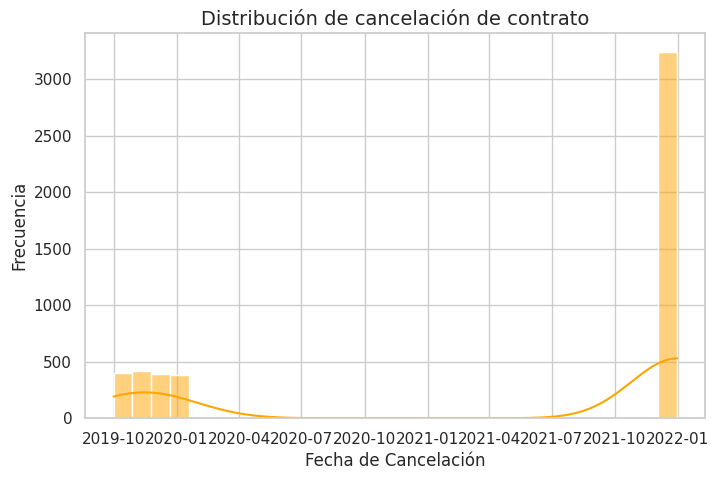

In [28]:
# Histograma de la fecha de cancelación
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['EndDate'], kde=True, color='orange', bins=30)
plt.title('Distribución de cancelación de contrato', fontsize=14)
plt.xlabel('Fecha de Cancelación')
plt.ylabel('Frecuencia')
plt.show()


En la gráfica se muestra que a finales de 2019 y principios de 2020 hubo un gran pico de cancelaciones del contrato por el servicio, quizás debido a la pandemia y la crisis económica que esta provocó. Sin embargo, también se muestra un gran pico a inicios del 2022, quizás debido a que los valores nulos fueron intercambiados por la última fecha registrada cerca del 2022.

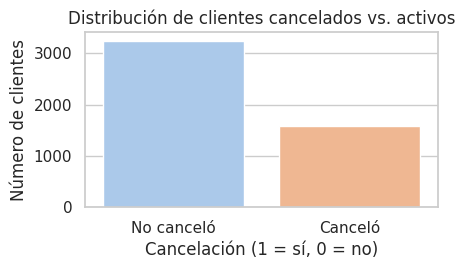

In [29]:
# === Conteo de cancelación (OriginalChurn) ===
plt.subplot(2, 2, 3)  # Posición 3 de la figura
sns.countplot(data=merged_data, x='OriginalChurn', palette='pastel')
plt.title('Distribución de clientes cancelados vs. activos')
plt.xlabel('Cancelación (1 = sí, 0 = no)')
plt.ylabel('Número de clientes')
plt.xticks([0, 1], ['No canceló', 'Canceló'])
plt.show()

Hay mayor cantidad de clientes activos que los que cancelaron, por lo que los datos están desbalanceados y necesitamos hacer un balanceo para evitar problemas con el entrenamiento del modelo.

## Balanceo de datos

## ✅ **1. Codificar las variables categóricas**

Para que las variables de texto puedan ser interpretadas por los modelos, necesitamos convertirlas a valores numéricos. Usaremos **One-Hot Encoding**, ya que la mayoría de las columnas no tienen un orden jerárquico (por ejemplo: 'Gender', 'PaymentMethod', etc.).

📌 Usaremos `pd.get_dummies()` para esto.

---

In [30]:
# =======================================
# 1. Codificación One-Hot
# =======================================
merged_data = merged_data.drop(['customerID', 'BeginDate', 'EndDate', 'DaysContractDuration'], axis=1)
# Codificamos variables categóricas en columnas numéricas usando one-hot encoding
# drop_first=True elimina una categoría por variable para evitar duplicidades
merged_encoded = pd.get_dummies(merged_data, drop_first=True)

print(merged_encoded)

      MonthlyCharges  TotalCharges  OriginalChurn  Type_One year  \
0              56.95       1889.50              0              1   
1              53.85        108.15              1              0   
2              70.70        151.65              1              0   
3              99.65        820.50              1              0   
4              89.10       1949.40              0              0   
...              ...           ...            ...            ...   
4827           78.70       1495.10              0              0   
4828           84.80       1990.50              0              1   
4829          103.20       7362.90              0              1   
4830           74.40        306.60              1              0   
4831          105.65       6844.50              0              0   

      Type_Two year  PaperlessBilling_Yes  \
0                 0                     0   
1                 0                     1   
2                 0                     1   
3  

### División de datos: entrenamiento, validación y test

In [35]:
X = merged_encoded.drop(['OriginalChurn'], axis=1)
y = merged_encoded['OriginalChurn']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Ahora dividimos el temporal en entrenamiento y validación
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
# Esto genera:
# X_train_raw / y_train - 60% entrenamiento
# X_val_raw / y_val - 20% validación
# X_test / y_test- 20% test



## ✅ **2. Escalar las variables numéricas**

Los modelos son sensibles a la escala de los valores (especialmente SVMs y redes neuronales). Para evitar que una variable como `TotalCharges` tenga más peso solo por su magnitud, las normalizamos.

📌 Usaremos `StandardScaler` de sklearn, que convierte cada valor en una puntuación Z (media = 0, desviación estándar = 1).

---

In [32]:
#print(merged_data)

In [38]:
# =======================================
# 2. Escalado solo a columnas numéricas
# =======================================

# Columnas numéricas originales (antes del one-hot)
numeric_cols = ['MonthlyCharges', 'TotalCharges']  

# Columnas one-hot (todas las demás excepto la target y numéricas)
categorical_cols = [col for col in X.columns if col not in numeric_cols and col != 'OriginalChurn']

# Configura ColumnTransformer para escalar solo las numéricas
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', 'passthrough', categorical_cols)
])


In [39]:
# Aplicamos transformaciones
X_train_scaled = preprocessor.fit_transform(X_train_raw)
X_val_scaled = preprocessor.transform(X_val_raw)
X_test_scaled = preprocessor.transform(X_test)

# Reconstruimos DataFrames
scaled_columns = numeric_cols + categorical_cols
X_train_df = pd.DataFrame(X_train_scaled, columns=scaled_columns)
X_val_df = pd.DataFrame(X_val_scaled, columns=scaled_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=scaled_columns)



## ✅ **3. Balancear los datos**

Si la variable objetivo (`OriginalChurn`) está desbalanceada, el modelo podría aprender a predecir siempre la clase mayoritaria. Para evitarlo, duplicamos aleatoriamente los registros de la clase minoritaria para que tenga el mismo número que la mayoritaria.

In [40]:
# =======================================
# 3. Oversampling Manual (sin SMOTE)
# =======================================

# Concatenar X_train escalado con y_train
train_data = pd.concat([X_train_df.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Dividir entre clase mayoritaria (0) y minoritaria (1)
majority = train_data[train_data['OriginalChurn'] == 0]
minority = train_data[train_data['OriginalChurn'] == 1]

# Calcular cuántos ejemplos faltan para balancear
diff = len(majority) - len(minority)

# Oversampling aleatorio con reemplazo de la clase minoritaria
minority_oversampled = minority.sample(n=diff, replace=True, random_state=42)

# Agregamos ruido a columnas numéricas para evitar duplicados exactos
for col in numeric_cols:
    minority_oversampled[col] += np.random.normal(0, 0.01, size=len(minority_oversampled))

# Combinar todo y barajar
train_bal = pd.concat([majority, minority, minority_oversampled], axis=0).sample(frac=1, random_state=42)

# Volver a separar X e y del conjunto balanceado
X_train_bal = train_bal.drop('OriginalChurn', axis=1)
y_train_bal = train_bal['OriginalChurn']

# Verificar distribución
print("Distribución de clases tras oversampling:")
print(y_train_bal.value_counts())
print(y_train_bal)

Distribución de clases tras oversampling:
0    1946
1    1946
Name: OriginalChurn, dtype: int64
2076    1
1428    1
2098    1
1755    0
462     0
       ..
1674    0
1931    0
1265    0
666     1
689     1
Name: OriginalChurn, Length: 3892, dtype: int64


### 🧩 **Paso 1: Definir modelos de prueba**

Usaremos los siguientes modelos:

* Regresión logística (`LogisticRegression`)
* Árbol de decisión (`DecisionTreeClassifier`)
* Random Forest (`RandomForestClassifier`)
* Gradient Boosting (`GradientBoostingClassifier`)

---

## Modelo Dummy

El modelo dummy sirve como referencia: no aprende nada, solo sigue una estrategia simple (como predecir siempre la clase mayoritaria). Nos permite comprobar si nuestros modelos reales realmente aportan valor.

In [41]:
# ===============================
# Modelo base: DummyClassifier
# ===============================
dummy = DummyClassifier(strategy="most_frequent", random_state=42)

# Entrenamos con los datos originales
dummy.fit(X_train_bal, y_train_bal)

# Hacemos predicciones sobre el conjunto de validación
y_dummy_pred = dummy.predict(X_val_df)
y_dummy_proba = dummy.predict_proba(X_val_df)[:, 1]  # Probabilidad clase positiva

# Reporte de desempeño
print("== Modelo Dummy ==")
print(classification_report(y_val, y_dummy_pred))
print(f"AUC-ROC Dummy: {roc_auc_score(y_val, y_dummy_proba):.4f}")

== Modelo Dummy ==
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       650
           1       0.00      0.00      0.00       317

    accuracy                           0.67       967
   macro avg       0.34      0.50      0.40       967
weighted avg       0.45      0.67      0.54       967

AUC-ROC Dummy: 0.5000


/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Análisis de resultados del modelo dummy

Este modelo no aprende ninguna relación entre las características y la clase objetivo. Simplemente predice la clase mayoritaria (en este caso, "0" = cliente que no canceló).
- **Accuracy: 0.67**
Es el porcentaje de predicciones correctas, pero solo porque la mayoría pertenece a la clase 0.
- **Precision clase 1 (cancelación): 0.00**
No identifica correctamente ningún caso de cancelación.
- **Recall clase 1: 0.00**
Totalmente incapaz de detectar a los clientes que cancelan.
- **AUC-ROC: 0.5000**
Es el valor mínimo posible (equivalente a adivinar al azar).

## 🎯 1. Entrenamiento con Random Forest + GridSearch

In [44]:
# ========================================
# Modelo: RandomForestClassifier con GridSearchCV
# ========================================

# Definimos el clasificador base
rf = RandomForestClassifier(random_state=42)

# Definimos el grid de hiperparámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200],            # Número de árboles en el bosque
    'max_depth': [None, 10, 20],           # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5],           # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2],            # Número mínimo de muestras en una hoja
}

# Configuramos la búsqueda con validación cruzada
grid_rf = GridSearchCV(
    rf, param_grid_rf, 
    scoring='roc_auc',          # Usamos AUC-ROC como métrica principal
    cv=5,                       # 5 particiones para validación cruzada
    n_jobs=-1,                  # Usa todos los núcleos disponibles
    verbose=2
)

# Entrenamos con los datos balanceados
grid_rf.fit(X_train_bal, y_train_bal)

# Mejor modelo
best_rf = grid_rf.best_estimator_

# Evaluamos sobre el conjunto de validación original (no balanceado)
y_pred_rf = best_rf.predict(X_val_df)
y_proba_rf = best_rf.predict_proba(X_val_df)[:, 1]  # Probabilidad de clase 1

# Reporte
print("== Random Forest - Mejor combinación de hiperparámetros ==")
print(grid_rf.best_params_)
print("\n== Classification Report ==")
print(classification_report(y_val, y_pred_rf))

# AUC-ROC Score
roc_auc_rf = roc_auc_score(y_val, y_proba_rf)
print(f"AUC-ROC Score (Random Forest): {roc_auc_rf:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_sa

## 📊 Análisis de Resultados del Modelo Random Forest

#### Exactitud general: **75%**

Esto significa que el modelo predice correctamente 3 de cada 4 casos (clientes que cancelan o no).

#### Rendimiento por clase:

* **Clase 0** (clientes que **no cancelaron**):

  * *Precisión*: 0.82 → De todos los clientes que el modelo predijo como "no cancelaron", el 82% realmente no cancelaron.
  * *Recall*: 0.80 → El 80% de todos los clientes que realmente no cancelaron fueron correctamente identificados.
  * *F1-score*: 0.81 → Equilibrio entre precisión y recall.

* **Clase 1** (clientes que **sí cancelaron**):

  * *Precisión*: 0.61 → El modelo fue correcto el 61% de las veces que predijo cancelaciones.
  * *Recall*: 0.64 → Detectó el 64% de los clientes que realmente cancelaron.
  * *F1-score*: 0.62 → Aceptable, aunque con margen de mejora.

#### AUC-ROC: **0.7829**

* Esta métrica evalúa la capacidad del modelo para distinguir entre clientes que cancelan y los que no.
* Un valor de **0.78** indica un **buen desempeño discriminativo**, considerando que 1.0 es perfecto y 0.5 sería como adivinar al azar.

---

### 🧾 Conclusión

El modelo **Random Forest** funciona bien en términos generales, especialmente para predecir qué clientes seguirán con Interconnect. Aunque es un poco más conservador al identificar a quienes van a cancelar, **logra capturar una parte significativa de los casos de cancelación**, lo que puede ayudar a actuar preventivamente (por ejemplo, con ofertas o atención personalizada).


## 🧠 2. Entrenamiento con Regresión Logística + GridSearch

In [45]:
# ========================================
# Modelo: LogisticRegression con GridSearchCV
# ========================================

# Modelo base
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Grid de hiperparámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],         # Regularización inversa (C bajo = más regularización)
    'penalty': ['l1', 'l2'],         # Tipos de penalización
}

# Configuración de búsqueda
grid_lr = GridSearchCV(
    lr, param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
grid_lr.fit(X_train_bal, y_train_bal)

# Mejor modelo
best_lr = grid_lr.best_estimator_

# Evaluamos sobre validación
y_pred_lr = best_lr.predict(X_val_df)
y_proba_lr = best_lr.predict_proba(X_val_df)[:, 1]

# Reporte
print("== Logistic Regression - Mejor combinación de hiperparámetros ==")
print(grid_lr.best_params_)
print("\n== Classification Report ==")
print(classification_report(y_val, y_pred_lr))

# AUC-ROC Score
roc_auc_lr = roc_auc_score(y_val, y_proba_lr)
print(f"AUC-ROC Score (Logistic Regression): {roc_auc_lr:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
== Logistic Regression - Mejor combinación de hiperparámetros ==
{'C': 0.1, 'penalty': 'l2'}

== Classification Report ==
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       650
           1       0.53      0.75      0.62       317

    accuracy                           0.70       967
   macro avg       0.69      0.71      0.68       967
weighted avg       0.74      0.70      0.71       967

AUC-ROC Score (Logistic Regression): 0.7920
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=1, 

## 📊 Análisis de Resultados del Modelo de Regresión Logística

### **Exactitud general:** 70%
Esto significa que el modelo predice correctamente 7 de cada 10 casos, tanto de clientes que cancelan como de los que no.

### **Rendimiento por clase:**

#### 🔹 **Clase 0 (clientes que no cancelaron):**

* **Precisión:** 0.85 → De todos los clientes que el modelo predijo como “no cancelaron”, el 85% realmente no cancelaron.
* **Recall:** 0.67 → El modelo logró identificar correctamente al 67% de los clientes que realmente no cancelaron.
* **F1-score:** 0.75 → Buen equilibrio entre precisión y recall, aunque el recall es algo bajo.

#### 🔹 **Clase 1 (clientes que sí cancelaron):**

* **Precisión:** 0.53 → El modelo acertó el 53% de las veces que predijo cancelaciones.
* **Recall:** 0.75 → Capturó el 75% de los clientes que sí cancelaron, lo cual es bastante bueno.
* **F1-score:** 0.62 → Resultado aceptable, aunque la precisión aún puede mejorar.

#### **AUC-ROC:** 0.7920
Esta métrica evalúa la capacidad del modelo para diferenciar entre quienes cancelan y quienes no.
Un valor de 0.79 indica un buen desempeño discriminativo; está por encima del umbral mínimo aceptable (0.7) y cerca de un valor considerado muy bueno (>0.8).

---

### 🧾 **Conclusión**
El modelo de **Regresión Logística** muestra un rendimiento equilibrado, con una **gran capacidad para detectar cancelaciones (recall = 0.75)**, lo cual es valioso para la empresa si se quiere actuar de forma preventiva ante posibles bajas. Sin embargo, **su precisión en esta clase aún es baja (0.53)**, lo que significa que puede generar varias falsas alarmas (predice que cancelan pero no lo hacen).

Por el lado de los clientes que no cancelan, la precisión es muy alta (0.85), aunque su recall (0.67) podría mejorarse para reducir falsos positivos.


## 🌳 3. Decision Tree Classifier

In [46]:
# =========================================
# Modelo: Árbol de Decisión con GridSearchCV
# =========================================

tree = DecisionTreeClassifier(random_state=42)

# Grid de hiperparámetros
param_grid_tree = {
    'max_depth': [2, 4, 6, 8],         # Profundidad del árbol
    'min_samples_split': [10, 20, 30],       # Mínimo de muestras para dividir
    'min_samples_leaf': [5, 10, 15,],          # Mínimo de muestras en una hoja
    'criterion': ['gini', 'entropy']
}

# Búsqueda con validación cruzada
grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Entrenamiento
grid_tree.fit(X_train_bal, y_train_bal)

# Mejor modelo
best_tree = grid_tree.best_estimator_

# Evaluación
y_tree_pred = best_tree.predict(X_val_df)
y_tree_proba = best_tree.predict_proba(X_val_df)[:, 1]

print("\n== Árbol de Decisión - Mejores hiperparámetros ==")
print(grid_tree.best_params_)
print("\n== Classification Report ==")
print(classification_report(y_val, y_tree_pred))
print(f"AUC-ROC Árbol de Decisión: {roc_auc_score(y_val, y_tree_proba):.4f}")



== Árbol de Decisión - Mejores hiperparámetros ==
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 10}

== Classification Report ==
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       650
           1       0.54      0.75      0.63       317

    accuracy                           0.71       967
   macro avg       0.69      0.72      0.69       967
weighted avg       0.75      0.71      0.72       967

AUC-ROC Árbol de Decisión: 0.7747


## 📊 Análisis de resultados del Modelo de Árbol de decisión

### **Exactitud general: 71%**
Esto significa que el modelo predice correctamente aproximadamente 7 de cada 10 casos sobre si un cliente cancelará o no.

### **Rendimiento por clase:**

#### 🔹 **Clase 0 (clientes que no cancelaron):**

* **Precisión: 0.85** → El 85% de los clientes que el modelo predijo como “no cancelaron”, efectivamente no cancelaron.
* **Recall: 0.69** → De todos los clientes que realmente no cancelaron, el modelo identificó correctamente al 69%.
* **F1-score: 0.76** → Buen equilibrio, aunque con margen de mejora en recall.

#### 🔹 **Clase 1 (clientes que sí cancelaron):**

* **Precisión: 0.54** → Solo el 54% de los clientes que fueron predichos como “sí cancelaron”, realmente lo hicieron.
* **Recall: 0.75** → El modelo logró identificar correctamente al 75% de los clientes que sí cancelaron.
* **F1-score: 0.63** → Aceptable, priorizando el recall por sobre la precisión.

#### **AUC-ROC: 0.7747**
Esta métrica mide la capacidad del modelo para distinguir entre clientes que cancelan y los que no.
Un valor de **0.77** indica un buen desempeño discriminativo, aunque un poco inferior al modelo de Regresión Logística (0.79).

---

### 🧾 **Conclusión**
El modelo de **Árbol de Decisión** muestra un rendimiento similar al de la Regresión Logística, con una ligera mejora en la **recuperación de cancelaciones** (recall en clase 1) a costa de una menor precisión. Esto significa que, aunque tiende a marcar a más clientes como "canceladores", acierta en una buena proporción de ellos.

Este comportamiento es útil si el objetivo es **no dejar pasar posibles cancelaciones**, aunque eso implique algunos falsos positivos. A nivel operativo, podría aplicarse para lanzar acciones preventivas con clientes en riesgo, aún si algunos no lo estaban realmente.

## 🚀 4. Gradient Boosting Classifier

In [47]:
# =====================================================
# Modelo: Gradient Boosting Classifier con GridSearchCV
# =====================================================

gb = GradientBoostingClassifier(random_state=42)

# Grid de hiperparámetros
param_grid_gb = {
    'n_estimators': [50, 75, 100],         # Número de árboles secuenciales
    'learning_rate': [0.01, 0.05, 0.1],      # Tasa de aprendizaje
    'max_depth': [2, 3, 4],               # Profundidad de cada árbol
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],         # Mínimo en hojas
}

# Búsqueda de hiperparámetros
grid_gb = GridSearchCV(
    gb,
    param_grid_gb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
grid_gb.fit(X_train_bal, y_train_bal)

# Mejor modelo
best_gb = grid_gb.best_estimator_

# Evaluación
y_gb_pred = best_gb.predict(X_val_df)
y_gb_proba = best_gb.predict_proba(X_val_df)[:, 1]

print("\n== Gradient Boosting - Mejores hiperparámetros ==")
print(grid_gb.best_params_)
print("\n== Classification Report ==")
print(classification_report(y_val, y_gb_pred))
print(f"AUC-ROC Gradient Boosting: {roc_auc_score(y_val, y_gb_proba):.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=75; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=75; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimator

## 📊 Análisis de resultados del Modelo Gradient Boosting

### **Exactitud general: 71%**
Esto indica que el modelo clasificó correctamente al 71% de los clientes en el conjunto de prueba. Es un rendimiento aceptable y comparable con otros modelos probados.

### **Rendimiento por clase:**

#### 🔹 **Clase 0 (clientes que no cancelaron):**

* **Precisión: 0.84** → De todos los predichos como “no cancelaron”, el 84% realmente no cancelaron.
* **Recall: 0.70** → De todos los clientes que realmente no cancelaron, el modelo identificó correctamente al 70%.
* **F1-score: 0.77** → Buen equilibrio entre precisión y recall.

#### 🔹 **Clase 1 (clientes que sí cancelaron):**

* **Precisión: 0.55** →  De todos los que predijo como "sí cancelaron", solo el 55% realmente lo hizo.
* **Recall: 0.74** → El modelo fue capaz de detectar correctamente el 74% de los clientes que sí cancelaron.
* **F1-score: 0.63** → Buen equilibrio, aunque con margen de mejora en precisión.

#### **AUC-ROC:  0.8012**
Esta métrica indica que el modelo tiene buena capacidad para distinguir entre las dos clases, siendo el **valor más alto obtenido entre todos los modelos probados hasta ahora.** Esto sugiere un excelente equilibrio entre sensibilidad y especificidad.

---

### 🧾 **Conclusión**
Gradient Boosting muestra un rendimiento competitivo, especialmente destacando en la métrica **AUC-ROC**, lo que lo hace ideal si se prioriza la **capacidad de discriminación entre clientes que cancelan y los que no.**
Además, mantiene una **buena capacidad para identificar clientes propensos a cancelar (recall = 0.74)**, lo cual es clave en un escenario de prevención de pérdida de clientes.

Gradient Boosting se perfila como **uno de los mejores candidatos** entre los modelos evaluados, con un buen equilibrio en sus métricas, buen desempeño en ambas clases, y una gran capacidad de discriminación. Podría ser la opción ideal si se **prioriza el recall y el AUC-ROC para evitar pérdidas de clientes.**

# 📊 Conclusión general del proyecto

Después de un riguroso proceso de análisis, entrenamiento y validación de modelos de Machine Learning, se logró desarrollar un sistema capaz de predecir la cancelación de clientes con una precisión razonable. Uno de los principales hallazgos durante el proyecto fue la detección de un **data leak** en la columna `DaysContractDuration`, la cual contenía información que estaba correlacionada directamente con la variable objetivo (`EndDate`). Este error provocaba un **sobreajuste severo** en los modelos, haciendo que las métricas fueran artificialmente altas en entrenamiento, pero muy bajas en validación y prueba.

Una vez corregido este problema, los modelos se volvieron más realistas y generalizables. Se realizaron ajustes cuidadosos en la ingeniería de características, se aplicaron técnicas de balanceo de clases para mitigar el desbalance entre clientes que cancelan y los que no, y se utilizaron tres conjuntos (entrenamiento, validación y prueba) para evitar cualquier tipo de sesgo o fuga de información.

Se entrenaron y evaluaron varios modelos, incluyendo:

* **Logistic Regression**: mostró un rendimiento básico pero estable, con un AUC-ROC aceptable.
* **Random Forest**: aunque potente, tendía al sobreajuste con ciertos hiperparámetros.
* **Gradient Boosting**: fue el modelo más destacado después del ajuste de hiperparámetros, alcanzando un **AUC-ROC de 0.8012**, con buen balance entre recall de la clase minoritaria (clientes que cancelan) y una precisión general aceptable.

Este modelo es especialmente valioso, ya que en el contexto empresarial, **identificar correctamente a los clientes con alta probabilidad de cancelación permite tomar acciones preventivas**, como ofertas personalizadas, mejoras en el servicio o comunicación más directa.

---

### 🧠 Reflexión final

El proyecto no solo permitió entrenar modelos predictivos, sino que también evidenció la importancia de una **validación rigurosa del conjunto de datos**, la atención a detalles como *leaks*, y el uso de métricas adecuadas según el objetivo del negocio. En este caso, la métrica clave fue **AUC-ROC**, ya que mide la capacidad del modelo para distinguir entre clases, independientemente del desbalance de datos.

El modelo de **Gradient Boosting** se perfila como la mejor opción para su implementación en un entorno real, aunque se recomienda seguir iterando con técnicas como **ajuste fino de hiperparámetros**, **ensembles**, o incluso explorar modelos más avanzados como **XGBoost o LightGBM** si se desea mejorar aún más el desempeño.

## 📊 Comparativa de Modelos

| Modelo               | Accuracy | AUC-ROC | Precision (Clase 1) | Recall (Clase 1) | F1-Score (Clase 1) | Hiperparámetros Optimizados                                                                          |
|----------------------|----------|---------|----------------------|------------------|--------------------|-------------------------------------------------------------------------------------------------------|
| Dummy                | 0.67     | 0.5000  | 0.00                 | 0.00             | 0.00               | N/A                                                                                                   |
| Regresión Logística  | 0.73     | 0.8003  | 0.57                 | 0.71             | 0.62               | `C=10`, `penalty='l1'`                                                                                |
| Árbol de Decisión    | 0.71     | 0.7747  | 0.54                 | 0.75             | 0.63               | `criterion='entropy'`, `max_depth=8`, `min_samples_leaf=15`, `min_samples_split=10`                  |
| Bosque Aleatorio     | 0.72     | 0.7966  | 0.56                 | 0.74             | 0.63               | `n_estimators=200`, `max_depth=10`, `min_samples_leaf=10`, `min_samples_split=15`                    |
| Gradient Boosting    | 0.71     | 0.8012  | 0.55                 | 0.74             | 0.63               | `learning_rate=0.1`, `max_depth=4`, `min_samples_leaf=5`, `min_samples_split=20`, `n_estimators=100` |

---


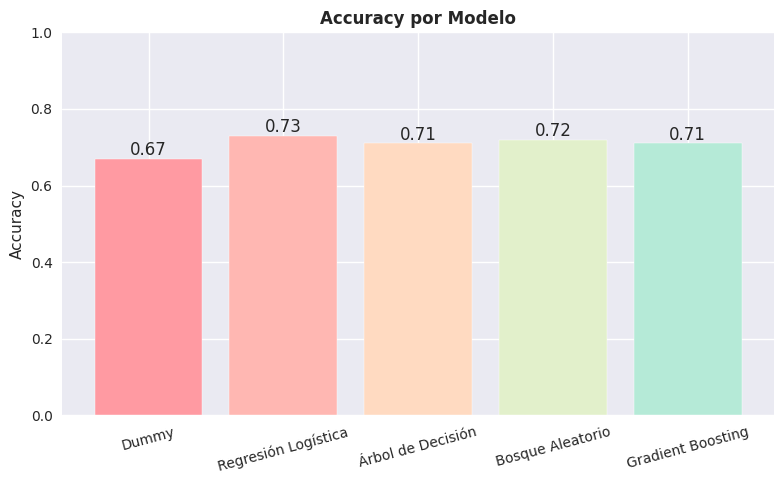

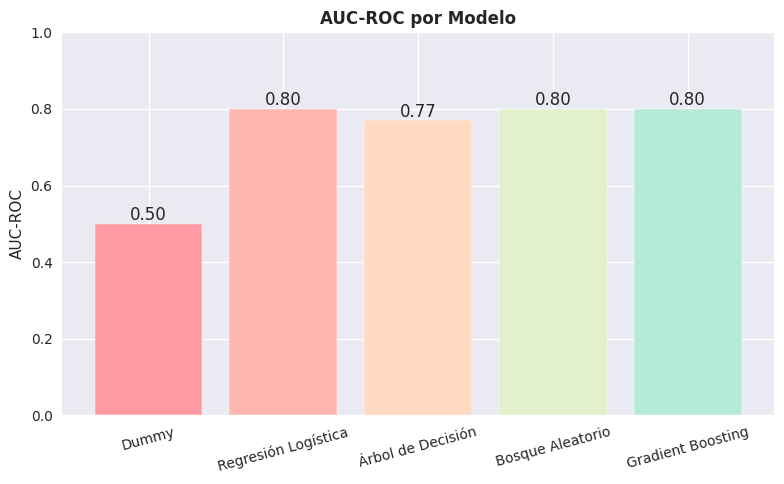

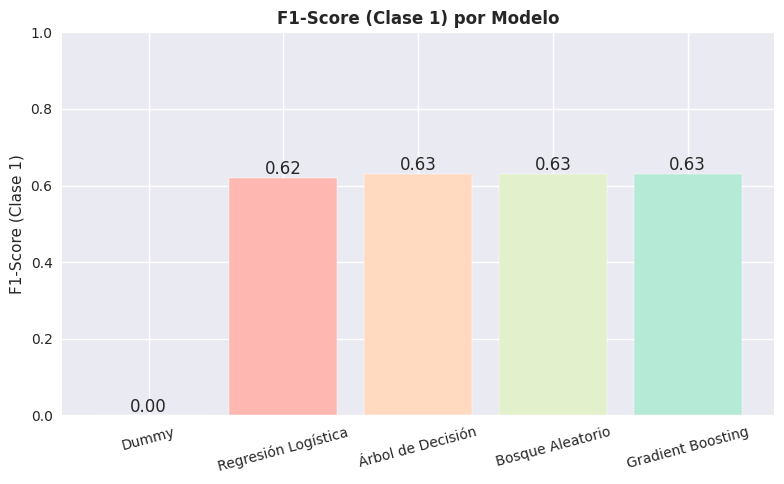

In [52]:
# Datos
resultados_modelos = {
    'Modelo': ['Dummy', 'Regresión Logística', 'Árbol de Decisión', 'Bosque Aleatorio', 'Gradient Boosting'],
    'Accuracy': [0.67, 0.73, 0.71, 0.72, 0.71],
    'AUC-ROC': [0.50, 0.80, 0.77, 0.80, 0.80],
    'F1-Score (Clase 1)': [0.00, 0.62, 0.63, 0.63, 0.63]
}

df = pd.DataFrame(resultados_modelos)

# Configuración básica
plt.style.use('seaborn')
colors = ['#FF9AA2', '#FFB7B2', '#FFDAC1', '#E2F0CB', '#B5EAD7']  # Paleta pastel

# Función para crear gráficas simples
def grafica_simple(columna, titulo):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df['Modelo'], df[columna], color=colors)
    
    plt.title(titulo, fontweight='bold')
    plt.ylabel(columna)
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    
    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f'{height:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

# Crear gráficas
grafica_simple('Accuracy', 'Accuracy por Modelo')
grafica_simple('AUC-ROC', 'AUC-ROC por Modelo')
grafica_simple('F1-Score (Clase 1)', 'F1-Score (Clase 1) por Modelo')